2024-2 언어데이터과학 기말프로젝트 최종보고서

# AI Hub 한국어-영어 번역 말뭉치를 통한 한국어 피동문과 영어 수동문의 대응 양상 분석

2021-14058 이예은

## 1 서론

### 1.1 연구 배경 및 목적

 전통적인 관점에서 한국어는 영어에 비해 수동/피동 표현이 적게 나타나는 언어로 여겨진다. 이에 대한 대표적인 근거는 다음과 같다. (1) 수동문은 영어처럼 주어(subject)가 두드러지는 언어에서 흔히 나타나는 반면, 한국어처럼 주제(topic)가 중심인 언어에서는 드물거나 주변적인 위치를 차지한다. (2) 한국어에서는 능동문에서도 행동주(agent)를 생략할 수 있지만, 영어에서 행동주를 생략하기 위해서는 수동태 문장 구조를 사용해야 한다. 
 이러한 이유로 한국어에서 수동/피동 표현은 영어에 비해 생산성이 낮다고 평가되며, 영어 수동 표현은 한국어에서 피동형이 아닌 능동형으로 번역될 것이 권장되고 실제 번역에서도 그러한 경향을 보인다. 관련 연구가 주로 영한 번역에서 진행된 반면, 본 프로젝트는 한영 번역 말뭉치 데이터를 활용하여 두 언어 간 수동/피동 표현의 생산성 차이를 비교 검증하고자 한다. 
 구체적으로, 한영 번역 데이터에서 영어 수동문이 한국어 능동문이나 피동문에서 생성된 비율을 분석할 것이다. 만약 한국어 원문이 능동문임에도 영어 번역문에서 수동 표현이 선택된 비율이 높다면, 이는 영어에서 수동 표현이 문맥적으로 더 생산적인 선택이 될 가능성을 시사할 것이다. 이를 통해 두 언어 간 수동/피동 표현의 상대적 생산성을 정량적으로 평가하고, 번역 과정에서 드러나는 언어적 특성을 규명하는 데 기여하고자 한다.

### 1.2 연구 계획 대비 목표 달성 결과

([연구계획서](./proposal.pdf)에 작성한 내용이 계획대로 실행되었는지 쓴다.)

||계획|실행|결과|
|--|--|--|--|
|데이터 수집|[[AI Hub]]에서 [한국어-영어 번역(병렬) 말뭉치] 중 [대화체 데이터(10만 문장)] 다운로드|전체 달성|
|데이터 전처리|xlsx 파일 --> 데이터프레임 변환.|pandas를 사용하여 실행함.|전체 달성|
|데이터 가공1|데이터프레임이 구축되면 pandas 라이브러리와 정규표현식, spaCy, koNLPy, jamo 등의 자연어처리 라이브러리를 사용하여 각 영어 데이터와 한국어 데이터에서 수동 및 피동 표현을 감지한다.|[영어 수동문 감지 패턴 출처](https://stackoverflow.com/questions/74528441/detect-passive-or-active-sentence-from-text)|전체 달성|
|데이터 가공2|영어 수동문을 기준으로 전체 데이터를 필터링하고, 한국어 피동 표현을 기준으로 전체 데이터를 추가 필터링하는 교차 분석을 통해 연구 결과의 신뢰성을 높인다.|전체 데이터를 한국어 피동 표현을 기준으로 필터링할 때 사동 접사와 피동 접사를 구분하지 못하는 문제가 발생하여 오류 데이터가 다수 포함되었다. 이에 따라 원래 계획을 수정하여 영어 수동문을 기준으로만 데이터를 필터링했다. |일부 달성|
|데이터 활용|가공된 병렬 데이터에서 영어 수동문과 한국어 피동문의 대응 양상을 수치화해서 비교하고 시각화한다.||전체 달성|
|...|...|...|...|

## 2 연구 방법

### 2.1 코퍼스

[[AI Hub]] [한국어-영어 번역(병렬) 말뭉]는 AI 번역 엔진 개발을 위한 문어체 한영 번역 110 문장과 구어체 한영 번역 50만 문장으로 이루어져 있고, 구어체 데이터 중 프로젝트에서 사용한 대화체 데이터는 10만 문장을 포함하고 있다. 각 말뭉치는 주제별 xlsx 파일 형식으로 구분되어 있다. 대화체 데이터의 크기는 9MB이다.

### 2.2 텍스트 전처리

In [13]:
# 설치 필요 라이브러리
!pip install openpyxl
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install -U konlpy
!pip install jamo

# 필요한 라이브러리 임포트
import pandas as pd
from tqdm import tqdm
import re
import spacy
from spacy.matcher import Matcher
from konlpy.tag import Kkma
from jamo import h2j, j2hcj
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 71.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# 파일 경로 지정 및 데이터 읽기
file_path = './data/한국어-영어 번역(병렬) 말뭉치/2_conversation_200226.xlsx'
df = pd.read_excel(file_path)

# 데이터 구조 및 샘플 확인
print(df.info())  # 데이터 구조 및 열 정보 확인
print(df.head())  # 첫 몇 행 출력

# 데이터 전처리: 결측치 제거 및 필요한 열 선택
df = df.dropna()  # 결측치 제거
df = df[['원문', '번역문']]  # 필요한 열만 선택
# 전처리된 데이터 출력
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   대분류      100000 non-null  object
 1   소분류      100000 non-null  object
 2   상황       100000 non-null  object
 3   Set Nr.  100000 non-null  int64 
 4   발화자      100000 non-null  object
 5   원문       100000 non-null  object
 6   번역문      100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
    대분류 소분류       상황  Set Nr.  발화자                            원문  \
0  비즈니스  회의  의견 교환하기        1  A-1   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1  비즈니스  회의  의견 교환하기        1  B-1    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2  비즈니스  회의  의견 교환하기        1  A-2  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   
3  비즈니스  회의  의견 교환하기        1  B-2   네, 제가 연락해서 주문량을 2배로 늘리겠습니다.   
4  비즈니스  회의  의견 교환하기        2  A-1   지난 회의 마지막에 논의했던 안건을 다시 볼까요?   

                                                 번역문  
0  How is the market's reactio

### 2.3 데이터 가공
전체 데이터 중에서 영어 수동문을 감지하고, 영어 수동문이 포함된 데이터만 필터링해 그 범위 내에서 대응하는 한국어 원문의 피동 표현을 분석해 비교한다. 
### 2.3.1 영어 데이터 가공 - 영어 수동문 감지
영어 수동문 감지 패턴은 (https://stackoverflow.com/questions/74528441/detect-passive-or-active-sentence-from-text)의 솔루션을 참고해서 구성했다. 

In [15]:
# spaCy 모델 로드
nlp = spacy.load("en_core_web_sm")

# 수동문 감지 패턴 정의
'''
nsubjpass: nominal subject (passive)
aux: auxiliary
auxpass: auxiliary (passive)
VBN: verb, past participle
VBZ: verb, 3rd person singular present
RB: adverb 
''' 

matcher = Matcher(nlp.vocab)
passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}], 
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]
matcher.add("Passive", passive_rules)

# 수동문 개수 계산 함수
def count_passive_sentences(text):
    doc = nlp(text)  # 텍스트 처리
    matches = matcher(doc)  # Matcher로 패턴 매칭
    return len(matches)  # 매칭된 패턴 개수 반환

In [16]:
# 각 영어 문장에 대해 수동문 개수 계산
eng_passive_counts = []
for text in tqdm(eng, desc="Processing Sentences"):
    count = count_passive_sentences(text)
    eng_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["eng_passive_count"] = eng_passive_counts
df = df[df["eng_passive_count"] > 0].reset_index(drop=True) # 영어 수동문 기준 데이터 필터링

Processing Sentences: 100%|██████████| 100000/100000 [07:15<00:00, 229.83it/s]


In [28]:
df = df[df["eng_passive_count"] > 0].reset_index(drop=True) # 영어 수동문 기준 데이터 필터링

### 2.3.2 한국어 데이터 가공 - 한국어 피동문 감지
한국어 피동 표현은 다음과 같이 세 가지 유형으로 나누어 탐지했다.
1) 피동 접미사 "-이/히/리/기-"를 포함한 패턴
* 이 때 동사 어근 자체에 "이/히/리/기"가 포함되어 피동 표현이 잘못 감지되는 경우가 있는데, 대표적으로 발생하는 오류인 "드리다" 동사를 제외했다.
2) 보조동사 "-어지다"를 포함한 패턴
* 이 때 자모 분석을 통해 모음 탈락 조건에서 연결 어미 "어/아"가 생략되는 경우 또한 포함해서 감지하도록 설정했다.
3) 피동 접미사 "-되다", "-받다", "-당하다"를 포함한 패턴 
* 이 때 해당 표현이 접미사가 아닌 동사로 쓰이는 경우는 띄어쓰기 여부를 기준으로 필터링하여 제외했다.

In [43]:
# 형태소 분석기 로드
kkma = Kkma()

# 한국어 피동문 유형별 패턴 감지 함수
def count_korean_passive_sentences(text):
    tokens = kkma.pos(text)  # 형태소 분석
    
    # 각 피동 탐지 조건별 결과 저장
    detected_patterns = {
        "passive_suffix": [],
        "passive_auxiliary": [],
        "passive_verb": []
    }
    # 1. 피동 접미사 "-이/히/리/기-" 패턴 탐지
    # '드리다'와 같이 동사 어근에 '리'가 포함되어 잘못 감지되는 경우를 제외
    for tok in tokens:
        if tok[1] == 'VV' and tok[0].endswith(('이', '히', '리', '기')) and tok[0] not in {'드리', '모이'}: 
            detected_patterns["passive_suffix"].append(tok)

     # 2. 보조동사 "-어지다" 패턴 탐지
     # 자모 분석을 통해 모음 탈락 조건에서 연결 어미 "어/아"가 생략되는 경우 포함
    for i in range(len(tokens) - 2):
        if (tokens[i][1] == 'VV' and 
            (tokens[i+1][0] in {'어', '아'} or
            any(vowel in j2hcj(h2j(tokens[i][0][-1])) for vowel in {'ㅓ', 'ㅏ', 'ㅐ', 'ㅔ', 'ㅡ'})) and
            tokens[i+2][0] == '지'):
            detected_patterns["passive_auxiliary"].append((tokens[i], tokens[i+1], tokens[i+2]))

    # "-되다", "-받다", "-당하다" 패턴 탐지
    # 해당 표현이 접미사가 아닌 동사로 쓰이는 경우 제외 (띄어쓰기 여부를 기준으로 필터링)
    for tok in tokens:
        if tok[1] == 'VV' and re.search(r'^\s*받|^(되|당하)', tok[0]): 
            detected_patterns["passive_verb"].append(tok)
    
    # 총 탐지 개수 반환
    total_count = sum(len(matches) for matches in detected_patterns.values())
    return total_count

In [44]:
kor = df['원문']
eng = df['번역문']

In [45]:
# 각 한국어 문장에 대해 수동문 개수 계산
kor_passive_counts = []
for text in tqdm(kor, desc="Processing Sentences"):
    count = count_korean_passive_sentences(text)
    kor_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["kor_passive_count"] = kor_passive_counts
df = df[['원문', '번역문', 'kor_passive_count', 'eng_passive_count']]

Processing Sentences: 100%|██████████| 6467/6467 [01:45<00:00, 61.23it/s]


## 3. 연구 결과
### 3.1 현상 기술
영어 수동문을 기준으로 전체 데이터를 필터링했을 때, 감지된 영어 수동문과 한국어 피동 표현의 개수는 다음과 같다.

/tmp/ipykernel_2141/2168491970.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")


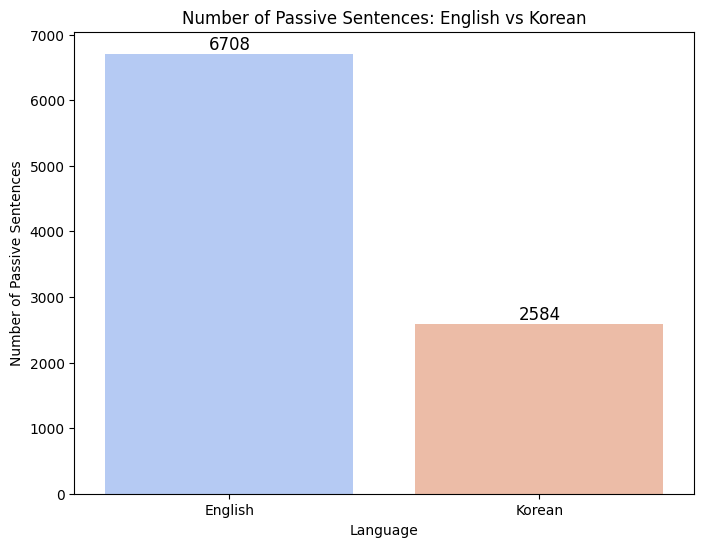

In [40]:
# 원문과 번역문 별 수동문 합계 계산 및 시각화
df_summary = df.melt(id_vars=["원문", "번역문"], 
                     value_vars=["eng_passive_count", "kor_passive_count"]) \
               .groupby("variable").sum().reset_index()
# 그래프 시각화
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")

# 각 바 위에 수동문 개수 표시
for i, v in enumerate(df_summary["value"]):
    ax.text(i, v + 10, f"{v}", ha="center", va="bottom", fontsize=12)

#그래프 제목 및 라벨 설정
plt.title("Number of Passive Sentences: English vs Korean")
plt.ylabel("Number of Passive Sentences")
plt.xlabel("Language")
plt.xticks([0, 1], ["English", "Korean"])

plt.show()

번역문인 영어 수동문을 분석의 중심으로 두고 해당 문장이 한국어 원문과의 관계에서 어떻게 해석되었는지를 피동 표현의 개수를 기준으로 시각화해서 분석했다.

/tmp/ipykernel_2141/787704757.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=analysis_counts.index, y=analysis_counts.values, palette="viridis")
/tmp/ipykernel_2141/787704757.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)


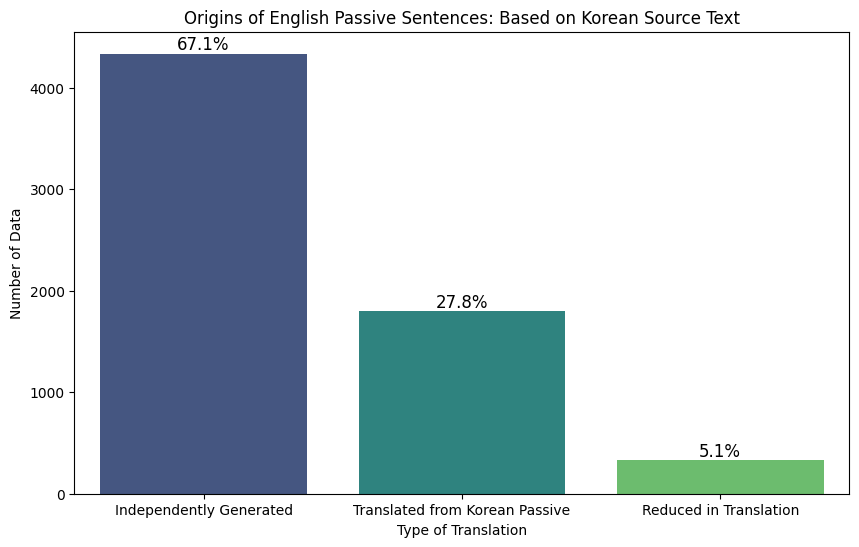

In [41]:
# 범주화: 줄어듦, 유지됨, 증가됨
def determine_passive_generation(row):
    if row["eng_passive_count"] > row["kor_passive_count"]:
        return "independently generated"  # 독자적으로 생성된 경우
    elif row["eng_passive_count"] == row["kor_passive_count"]:
        return "translated from Korean passive"  # 한국어 피동에서 번역된 경우
    else:
        return "reduced in English translation"  # 한국어 피동 표현이 능동으로 전환된 경우

df["passive_analysis"] = df.apply(determine_passive_generation, axis=1)

# 각 범주의 개수 계산
analysis_counts = df["passive_analysis"].value_counts()

# 퍼센트 계산
total = analysis_counts.sum()
percentages = (analysis_counts / total) * 100

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=analysis_counts.index, y=analysis_counts.values, palette="viridis")

for i, count in enumerate(analysis_counts.values):
    plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title("Origins of English Passive Sentences: Based on Korean Source Text")
plt.xlabel("Type of Translation")
plt.ylabel("Number of Data")
plt.xticks([0, 1, 2], ["Independently Generated", "Translated from Korean Passive", "Reduced in Translation"])
plt.show()

## 3.2. 분석 
1. 영어 피동 표현 개수 > 한국어 피동 표현 개수

이 경우, 영어 피동 표현이 독자적으로 생성되었을  가능성이 높다.
예를 들어 한국어 원문이 능동 표현이거나 피동 표현이 더 적었는데, 영어 번역에서 문맥상 수동 표현이 필요했을 가능성이 있다.

2. 영어 피동 표현 개수 == 한국어 피동 표현 개수

이 경우, 한국어 피동 표현이 구조적 변환 없이 그대로 영어 수동 표현으로 번역되어 생성되었을 가능성이 높다.

3. 영어 피동 표현 개수 < 한국어 피동 표현 개수

이 경우, 한국어 피동 표현 중 일부가 영어에서 능동 표현으로 번역되었을 가능성이 있다.
예를 들어 한국어에서는 피동 표현으로 쓰이지만 영어에서는 능동문으로 주로 쓰이는 표현들이 일부 있을 수 있다.

분석 결과 영어 피동 표현이 한국어 피동 표현보다 많은 경우가 67.1%로 많았다. 영어 피동 표현 개수가 한국어 원문의 피동 표현 개수와 같아 그대로 번역된 경우는 약 27.8%, 영어 피동 표현 개수가 한국어보다 적은 경우, 즉 한국어 피동 표현이 영어에서 능동으로 번역된 경우는 약 5.1%였다. 이는 영어 피동 표현이 한국어 원문과 관계 없이 독자적으로 생성되는 경우가 많으며, 영어에서 피동표현의 생산성이 높다는 것을 암시할 수 있다. 

In [51]:
# 1. 영어 피동 표현 개수 > 한국어 피동 표현 개수
case_1 = df[df["eng_passive_count"] > df["kor_passive_count"]]

# 2. 영어 피동 표현 개수 == 한국어 피동 표현 개수
case_2 = df[df["eng_passive_count"] == df["kor_passive_count"]]

# 3. 영어 피동 표현 개수 < 한국어 피동 표현 개수
case_3 = df[df["eng_passive_count"] < df["kor_passive_count"]]

# 각 케이스에서 몇 개의 샘플을 출력할지 설정 (예: 상위 3개 샘플)
print("Case 1 (영어 피동 > 한국어 피동):")
print(case_1[["원문", "번역문"]].head(3))  # 상위 3개 샘플

print("\nCase 2 (영어 피동 == 한국어 피동):")
print(case_2[["원문", "번역문"]].head(3))  # 상위 3개 샘플

print("\nCase 3 (영어 피동 < 한국어 피동):")
print(case_3[["원문", "번역문"]].head(3))  # 상위 3개 샘플


Case 1 (영어 피동 > 한국어 피동):
                                    원문  \
0            우리 제품은 어떤 방식으로 도쿄에 보내지나요?   
1  먼저 배로 도쿄 근처 항구까지 운반하고 그 후 차를 이용합니다.   
3        7월 29일부터 8월 2일까지가 공식적인 기간이에요.   

                                                                        번역문  
0                                How will our products be shipped to Tokyo?  
1  They'll be sent to Tokyo port by the ship, then transported by vehicles.  
3                       It's officially scheduled from July 29 to August 2.  

Case 2 (영어 피동 == 한국어 피동):
                                               원문  \
2                      교육 안내 메일 하단에 작은 글씨로 적혀있어요.   
10              좋은 생각인데, 진행하고 있던 일은 자동으로 저장이 되나요?   
13  회사에서 지원해주는 해외 출장 일일 경비가 어떻게 책정 되어있는지 혹시 아시나요?   

                                                                                                번역문  
2                     It was written in very small letters at the bottom of the notification email.  
10      I like the idea, but will it automatically

## 4 결론
이 연구에서는 AI Hub 한영 번역 말뭉치를 활용하여 영어 수동문과 한국어 피동문의 대응 양상을 분석하였다. 전체 데이터에서 영어 수동문을 포함한 데이터를 필터링한 뒤, 해당 데이터 내에서 대응하는 한국어 원문에서 피동 표현을 감지하였다. 한국어에서 번역된 영어 수동문의 기원을 조사한 결과, 한국어 원문에서는 피동 표현이 없었지만 영어로 번역되는 과정에서 독자적으로 수동 표현이 생성되는 경우가 67.1%로 가장 많았다. 그 다음으로는 한국어 피동 표현이 영어 수동문으로 그대로 유지된 경우가 27.8%, 능동문으로 변환된 경우가 5.1%로 나타났다. 이러한 분석 결과는 영어 수동 표현이 한국어 원문에 비해 빈도가 높고, 생산성이 높다는 기존 이론을 지지하는 근거로 볼 수 있다.

하지만 본 연구는 한국어 원문 문장의 피동 표현 여부를 기준으로 영어에서 수동 표현이 생성되었는지 여부를 완전히 확인하지 못했기 때문에, 한국어 피동문의 생산성에 대한 분석 결과를 전면적으로 일반화하기에는 한계가 있다. 따라서 한국어 피동 표현을 더 정교하게 감지할 수 있는 방법을 개발하여, 영어 수동문과 한국어 피동 표현을 기준으로 한 추가 분석을 진행하면, 더 신뢰성 있는 교차 검증과 분석이 가능할 것이다.